# CoMM on synthetic bimodal Trifeatures dataset

This notebook shows how to use CoMM on the synthetic bimodal-Trifeatures dataset (see Fig. 4 in [our paper](https://arxiv.org/abs/2409.07402)).




### Packages install

Let's start by installing and loading the required package for this notebook (if not already installed):

In [ ]:
%pip install torch
%pip install omegaconf
%pip install hydra-core
%pip install pytorch-lightning
%pip install scikit-learn
%pip install torchvision
%pip install tensorboard
%pip install pandas
%pip install einops
%pip install matplotlib

In [45]:
import sys
sys.path.append("../")
import numpy as np
import os
import torch
import torch.nn.parallel
import torch.optim
import torch.utils.data
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from dataset.trifeatures import TrifeaturesDataModule
from pytorch_lightning import Trainer
from pl_modules.comm import CoMM
from models.mmfusion import MMFusion
from models.input_adapters import PatchedInputAdapter
from models.alexnet import AlexNetEncoder
import warnings

In [46]:
torch.manual_seed(42) # for reproducibility
np.random.seed(42) 
warnings.filterwarnings("ignore", category=UserWarning) # avoids sklearn warnings

### Loading and visualizing the data

In [11]:

# Load the unbiased bimodal Trifeatures to learn redundant and unique information (Experiment 1)
data_module_R_U = TrifeaturesDataModule("CoMM", "bimodal", batch_size=64, num_workers=16, biased=False)

# Load the biased bimodal Trifeatures to learn synergistic interactions (Experiment 2)
data_module_S = TrifeaturesDataModule("CoMM", "bimodal", batch_size=64, num_workers=16, biased=True)

# The downstream tasks
downstream_task_S = TrifeaturesDataModule("Sup","bimodal", batch_size=64, num_workers=10, biased=False, task="synergy")
downstream_task_U1 = TrifeaturesDataModule("Sup","bimodal", batch_size=64, num_workers=10, biased=False, task="unique1")
downstream_task_R = TrifeaturesDataModule("Sup","bimodal", batch_size=64, num_workers=10, biased=False, task="share")

2400 images in train found.
200 images in test found.
2400 images in train found.
200 images in test found.
2400 images in train found.
200 images in test found.
2400 images in train found.
200 images in test found.
2400 images in train found.
200 images in test found.
2400 images in train found.
200 images in test found.
2400 images in train found.
200 images in test found.
2400 images in train found.
200 images in test found.
2400 images in train found.
200 images in test found.
2400 images in train found.
200 images in test found.


Shape is shared, texture is unique to each modality


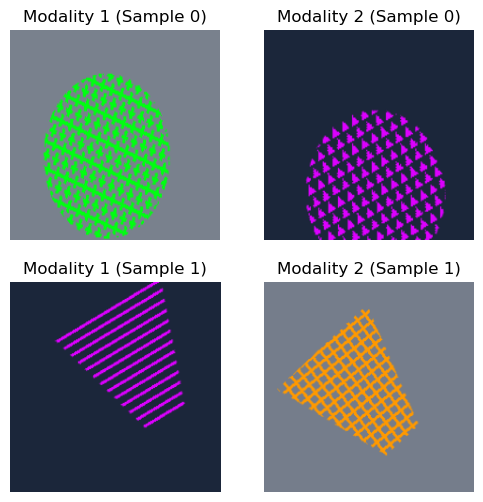

In [4]:
# Fetch 2 pairs of images (i.e. 2 data points)
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

def norm(x): return (255 * (x - x.min())/(x.max() - x.min())).int()

for i in range(2):
    pair, _ = downstream_task_S.val_dataset[i]
    img1, img2 = pair  # First and second modality
    img1, img2 = norm(img1).squeeze().permute(1, 2, 0), norm(img2).squeeze().permute(1, 2, 0)  # Convert to HWC format

    axes[i, 0].imshow(img1)
    axes[i, 0].set_title(f"Modality 1 (Sample {i})")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(img2)
    axes[i, 1].set_title(f"Modality 2 (Sample {i})")
    axes[i, 1].axis("off")
print("Shape is shared, texture is unique to each modality")

### Fit CoMM to Bimodal Trifeatures - Synergy

In [42]:
comm = CoMM(
    encoder=MMFusion(
        encoders=[ # Symmetric visual encoders
            AlexNetEncoder(latent_dim=512, global_pool=""), 
            AlexNetEncoder(latent_dim=512, global_pool="")
        ], 
        input_adapters=[ # Pach adapters for multimodal fusion
            PatchedInputAdapter(num_channels=256, stride_level=1, patch_size_full=1, dim_tokens=512, image_size=6),
            PatchedInputAdapter(num_channels=256, stride_level=1, patch_size_full=1, dim_tokens=512, image_size=6)
        ],
        embed_dim=512
    ),
    projection=CoMM._build_mlp(512, 512, 256),
    optim_kwargs=dict(lr=3e-4, weight_decay=1e-4),
    loss_kwargs=dict(temperature=0.1)
)

In [43]:
trainer = Trainer(inference_mode=False, max_epochs=100)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(comm, datamodule=data_module_S)

### Evaluate CoMM on synergy task

Extract the embedding and train a linear probe on top:

In [47]:
Z_train, y_train = comm.extract_features(downstream_task_S.train_dataloader())
Z_test, y_test = comm.extract_features(downstream_task_S.test_dataloader())

In [ ]:
linear_model = LogisticRegressionCV(Cs=5, n_jobs=10, scoring="balanced_accuracy").fit(Z_train.cpu().detach().numpy(), y_train.cpu().detach().numpy())

In [49]:
acc_s = linear_model.score(Z_test.cpu().detach().numpy(), y_test.cpu().detach().numpy())
print(f"CoMM score on synergy={100 * acc_s:.2f}%")


CoMM score on synergy=70.29%


### Fit CoMM on Bimodal Trifeatures - Uniqueness and Redundancy

In [50]:
comm = CoMM(
    encoder=MMFusion(
        encoders=[ # Symmetric visual encoders
            AlexNetEncoder(latent_dim=512, global_pool=""), 
            AlexNetEncoder(latent_dim=512, global_pool="")
        ], 
        input_adapters=[ # Pach adapters for multimodal fusion
            PatchedInputAdapter(num_channels=256, stride_level=1, patch_size_full=1, dim_tokens=512, image_size=6),
            PatchedInputAdapter(num_channels=256, stride_level=1, patch_size_full=1, dim_tokens=512, image_size=6)
        ],
        embed_dim=512
    ),
    projection=CoMM._build_mlp(512, 512, 256),
    optim_kwargs=dict(lr=3e-4, weight_decay=1e-4),
    loss_kwargs=dict(temperature=0.1)
)

In [53]:
trainer = Trainer(inference_mode=False, max_epochs=100)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(comm, datamodule=data_module_R_U)

### Evaluate CoMM on unique and redundant tasks

In [55]:
# Unique task
Z_train, y_train = comm.extract_features(downstream_task_U1.train_dataloader())
Z_test, y_test = comm.extract_features(downstream_task_U1.test_dataloader())

In [ ]:
linear_model = LogisticRegressionCV(Cs=5, n_jobs=10, scoring="balanced_accuracy").fit(Z_train.cpu().detach().numpy(), y_train.cpu().detach().numpy())

In [57]:
acc_u = linear_model.score(Z_test.cpu().detach().numpy(), y_test.cpu().detach().numpy())
print(f"CoMM accuracy on uniqueness={100 * acc_u:.2f}%")

CoMM accuracy on uniqueness=90.14%


In [58]:
# Redundant task
Z_train, y_train = comm.extract_features(downstream_task_R.train_dataloader())
Z_test, y_test = comm.extract_features(downstream_task_R.test_dataloader())

In [ ]:
linear_model = LogisticRegressionCV(Cs=5, n_jobs=10, scoring="balanced_accuracy").fit(Z_train.cpu().detach().numpy(), y_train.cpu().detach().numpy())

In [60]:
acc_r = linear_model.score(Z_test.cpu().detach().numpy(), y_test.cpu().detach().numpy())
print(f"CoMM accuracy on redundancy={100 * acc_r:.2f}%")

CoMM accuracy on redundancy=99.96%
